# IBM Applied Data Science Capstone Course by Coursera 

Week 5 Final Report

Comparing the two Boroughs from Mexico City with the highest Human Development Index (IDH) according to a study made in 2015: Benito Juarez and Mighel Hidalgo

Build a dataframe of neighborhoods in Benito Juarez and Mighel Hidalgo by colecting the data from Mexico City Data Portal

Obtain the venue data for the neighborhoods from Foursquare API

Explore and cluster the neighborhoods

Analize similarities and differences

## 1. Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from IPython.display import HTML


print('Libraries imported.')

Libraries imported.


In [2]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #3b3939'>{}<span style='color: #3b3939; font-size: 115%'>:</span></h2>"

## 2. Obtaining data from Mexico City Data Portal

In [3]:
## Read csv file into a pandas dataframe
link='https://datos.cdmx.gob.mx/explore/dataset/coloniascdmx/download/?format=csv&timezone=America/Guatemala&lang=es&use_labels_for_header=true&csv_separator=%2C'
data=pd.read_csv(link)
data.head()

,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
0,LOMAS DE CHAPULTEPEC,9.0,"19.4228411174,-99.2157935754","{""type"": ""Polygon"", ""coordinates"": [[[-99.2201...",16,MIGUEL HIDALGO,16-042,"4924, 4931, 4932, 4935, 4936, 4940, 4987","4923, 4937, 4938, 4939, 4942"
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),9.0,"19.4106158914,-99.2262487268","{""type"": ""Polygon"", ""coordinates"": [[[-99.2296...",16,MIGUEL HIDALGO,16-044,4963,4964
2,DEL BOSQUE (POLANCO),9.0,"19.4342189235,-99.2094037513","{""type"": ""Polygon"", ""coordinates"": [[[-99.2082...",16,MIGUEL HIDALGO,16-026,NaN,"4918, 4919"
3,PEDREGAL DE SANTA URSULA I,9.0,"19.314862237,-99.1477954505","{""type"": ""Polygon"", ""coordinates"": [[[-99.1458...",3,COYOACAN,03-135,"433, 500, 431, 513, 501","424, 425, 426, 430, 499"
4,AJUSCO I,9.0,"19.324571116,-99.1561602234","{""type"": ""Polygon"", ""coordinates"": [[[-99.1585...",3,COYOACAN,03-128,"376, 377, 378, 379, 404, 493, 498",374


In [4]:
## We can see that the latitude and longitude data is stored in a column labeled "Geo Point". 
## We will need to split this column in two to and store it in a temporary dataframe

Lat_Long=data['Geo Point'].str.split(',', expand=True)
Lat_Long.head(3)

,0,1
0,19.4228411174,-99.2157935754
1,19.4106158914,-99.2262487268
2,19.4342189235,-99.2094037513


In [5]:
## Now we will create a new dataframe using only the columns Colonia (Neighborhood), and Alcaldia (Burough)

Mexico_city=data[['ALCALDIA','COLONIA']].copy()
Mexico_city.head(3)

,ALCALDIA,COLONIA
0,MIGUEL HIDALGO,LOMAS DE CHAPULTEPEC
1,MIGUEL HIDALGO,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)
2,MIGUEL HIDALGO,DEL BOSQUE (POLANCO)


In [6]:
## Next we will add the latitude and longitude from the temporary dataframe and rename the columns.
Mexico_city['Latitude']=Lat_Long[0]
Mexico_city['Longitude']=Lat_Long[1]
Mexico_city.columns=['Borough','Neighborhood','Latitude','Longitude']
Mexico_city.head(3)

,Borough,Neighborhood,Latitude,Longitude
0,MIGUEL HIDALGO,LOMAS DE CHAPULTEPEC,19.4228411174,-99.2157935754
1,MIGUEL HIDALGO,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),19.4106158914,-99.2262487268
2,MIGUEL HIDALGO,DEL BOSQUE (POLANCO),19.4342189235,-99.2094037513


In [7]:
## Lets check the data type for each column

Mexico_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       1812 non-null   object
 1   Neighborhood  1812 non-null   object
 2   Latitude      1808 non-null   object
 3   Longitude     1808 non-null   object
dtypes: object(4)
memory usage: 28.4+ KB


In [8]:
## We'll need to convert Latitude and Longitud to real numbers to avoid problems down the road

Mexico_city['Latitude'] = Mexico_city['Latitude'].astype(float)
Mexico_city['Longitude'] = Mexico_city['Longitude'].astype(float)

Mexico_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       1812 non-null   object 
 1   Neighborhood  1812 non-null   object 
 2   Latitude      1808 non-null   float64
 3   Longitude     1808 non-null   float64
dtypes: float64(2), object(2)
memory usage: 42.5+ KB


In [9]:
Mexico_city.head(3)

,Borough,Neighborhood,Latitude,Longitude
0,MIGUEL HIDALGO,LOMAS DE CHAPULTEPEC,19.422841,-99.215794
1,MIGUEL HIDALGO,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),19.410616,-99.226249
2,MIGUEL HIDALGO,DEL BOSQUE (POLANCO),19.434219,-99.209404


## 3. Cleaning the data

In [10]:
## Because we will be using only two boroughs from the whole dataset we will create dataframe for each borough. 
## MH for Mighel Hidalgo and BJ for Benito Juarez

MH_data = Mexico_city[Mexico_city['Borough'].isin(['MIGUEL HIDALGO'])].reset_index(drop=True)
BJ_data = Mexico_city[Mexico_city['Borough'].isin(['BENITO JUAREZ'])].reset_index(drop=True)

In [11]:
## Lets check the dataframe for Mighel Hidalgo

MH_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       88 non-null     object 
 1   Neighborhood  88 non-null     object 
 2   Latitude      88 non-null     float64
 3   Longitude     88 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.1+ KB


In [12]:
## Lets check the dataframe for Benito Juarez

BJ_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       64 non-null     object 
 1   Neighborhood  64 non-null     object 
 2   Latitude      64 non-null     float64
 3   Longitude     64 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.6+ KB


#### Now that we verified both dataframes do not contain null values we can begin our exploratory analysis.

## 4. Creating maps of both boroughs

In [13]:
# get the coordinates of Benito Juarez
address = 'Benito Juarez, Mexico City'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude_BJ = location.latitude
longitude_BJ = location.longitude
print('The geograpical coordinate of Benito Juarez, Mexico City {}, {}.'.format(latitude_BJ, longitude_BJ))

The geograpical coordinate of Benito Juarez, Mexico City 19.3804695, -99.1632429340113.


In [14]:
# create map of Benito Juarez using latitude and longitude values
map_BJ = folium.Map(location=[latitude_BJ, longitude_BJ], zoom_start=13)

# add markers to map
for lat, lng, neighborhood in zip(BJ_data['Latitude'], BJ_data['Longitude'], BJ_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_BJ)  
    
map_BJ

In [17]:
# get the coordinates of Miguel Hidalgo
address = 'Miguel Hidalgo, Mexico City'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude_MH = location.latitude
longitude_MH = location.longitude
print('The geograpical coordinate of Miguel Hidalgo, Mexico City {}, {}.'.format(latitude_MH, longitude_MH))

The geograpical coordinate of Miguel Hidalgo, Mexico City 19.429614049999998, -99.19863845640572.


In [18]:
# create map of Miguel Hidalgo using latitude and longitude values
map_MH = folium.Map(location=[latitude_MH, longitude_MH], zoom_start=13)

# add markers to map
for lat, lng, neighborhood in zip(MH_data['Latitude'], MH_data['Longitude'], MH_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc3131',
        fill_opacity=0.7).add_to(map_MH)  
    
map_MH

## 5. Use the Foursquare API to explore the neighborhoods

In [1]:
# define Foursquare Credentials and Version
# @hidden_cell
CLIENT_ID = '0UCPDHSEHRQ5S3B3EWSXBY5M4WC4NQHI14W4W2ISLJT4PNVE' # your Foursquare ID
CLIENT_SECRET = 'LH455JTMLKFYMXYX0IK3Q4TBLYDXVJXXH22E4ZGZRWDYJN42' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT=100

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Benito Juarez

In [21]:
# Benito Juares venues

BJ_venues = getNearbyVenues(names=BJ_data['Neighborhood'],
                                   latitudes=BJ_data['Latitude'],
                                   longitudes=BJ_data['Longitude']
                                  )

NARVARTE V
PORTALES III
DEL VALLE VII
NAPOLES (AMPL)
LETRAN VALLE
NIOS HEROES DE CHAPULTEPEC
ZACAHUITZCO
NARVARTE III
MIRAVALLE
JOSEFA ORTIZ DE DOMINGUEZ
INDEPENDENCIA
INSURGENTES MIXCOAC
NAPOLES
NARVARTE I
PORTALES IV
TLACOQUEMECATL DEL VALLE
ACACIAS
IZTACCIHUATL
CREDITO CONSTRUCTOR
CIUDAD DE LOS DEPORTES
MIGUEL ALEMAN
CENTRO URBANO PRESIDENTE ALEMAN (U HAB)
GENERAL PEDRO MARIA ANAYA
SAN JOSE INSURGENTES
DEL VALLE IV
PORTALES I
NARVARTE VI
NONOALCO
MERCED GOMEZ
INSURGENTES SAN BORJA
ATENOR SALAS
DEL VALLE V
SAN PEDRO DE LOS  PINOS
NOCHE BUENA
DEL VALLE II
ALAMOS II
ACTIPAN
VILLA DE CORTES
ERMITA
MARIA DEL CARMEN
RESIDENCIAL EMPERADORES
PERIODISTA FRANCISCO ZARCO
MIXCOAC
SAN JUAN
STA CRUZ ATOYAC
DEL VALLE III
DEL VALLE VI
PORTALES II
NARVARTE II
POSTAL
OCHO DE AGOSTO
AMERICAS UNIDAS-DEL LAGO
EXTREMADURA INSURGENTES
ALBERT
MODERNA
NATIVITAS
SAN SIMON TICUMAC
DEL VALLE I
VERTIZ NARVARTE
XOCO
ALAMOS I
NARVARTE IV
PIEDAD NARVARTE
PORTALES ORIENTE


In [22]:
print(BJ_venues.shape)
BJ_venues.head(3)

(6400, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,NARVARTE V,19.386051,-99.15716,Almanegra Café,19.385326,-99.155343,Coffee Shop
1,NARVARTE V,19.386051,-99.15716,La Esperanza,19.385898,-99.157321,Bakery
2,NARVARTE V,19.386051,-99.15716,Costra,19.386832,-99.154611,Bakery


Let's check how many venues were returned for each neighborhood

In [23]:
BJ_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ACACIAS,100,100,100,100,100,100
ACTIPAN,100,100,100,100,100,100
ALAMOS I,100,100,100,100,100,100
ALAMOS II,100,100,100,100,100,100
ALBERT,100,100,100,100,100,100
AMERICAS UNIDAS-DEL LAGO,100,100,100,100,100,100
ATENOR SALAS,100,100,100,100,100,100
CENTRO URBANO PRESIDENTE ALEMAN (U HAB),100,100,100,100,100,100
CIUDAD DE LOS DEPORTES,100,100,100,100,100,100


In [24]:
BJ_data.shape[0], BJ_venues['Neighborhood'].unique().shape[0]

(64, 64)

We notice that there are 64 neighborhoods in the table and we had 64 neighborhoods before we got the data from Foursquare. This means that Foursquare returned data for all neighborhoods.

Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(BJ_venues['Venue Category'].unique())))

There are 225 uniques categories.


In [26]:
# print out the list of categories
BJ_venues['Venue Category'].unique()[:50]

array(['Coffee Shop', 'Bakery', 'Flower Shop',
       'Vegetarian / Vegan Restaurant', 'Pharmacy', 'Mexican Restaurant',
       'Ice Cream Shop', 'Southern / Soul Food Restaurant', 'Taco Place',
       'Seafood Restaurant', 'Lebanese Restaurant', 'Café',
       'Performing Arts Venue', 'Health Food Store', 'Russian Restaurant',
       'Paella Restaurant', 'Spa', 'Gymnastics Gym', 'Pizza Place',
       'German Restaurant', 'Greek Restaurant', 'Health & Beauty Service',
       'IT Services', 'BBQ Joint', 'Restaurant', 'Beer Bar', 'Food Truck',
       'Music Venue', 'Sandwich Place', 'Burger Joint',
       'Tapas Restaurant', 'Steakhouse', 'Salon / Barbershop', 'Brewery',
       'Italian Restaurant', 'Dance Studio', 'Burrito Place', 'Pet Store',
       'Supermarket', 'Gym / Fitness Center', 'Gastropub',
       'Breakfast Spot', 'Bar', 'Dessert Shop', 'American Restaurant',
       'Park', 'Yoga Studio', 'Frozen Yogurt Shop', 'Bistro',
       'Athletics & Sports'], dtype=object)

### Miguel Hidalgo

In [31]:
# Miguel Hidalgo venues

MH_venues = getNearbyVenues(names=MH_data['Neighborhood'],
                                   latitudes=MH_data['Latitude'],
                                   longitudes=MH_data['Longitude']
                                  )

LOMAS DE CHAPULTEPEC
LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)
DEL BOSQUE (POLANCO)
5 DE MAYO
PLUTARCO ELIAS CALLES
CHAPULTEPEC MORALES (POLANCO)
ANZURES
CUAUHTEMOC PENSIL
GRANADA (AMPL)
LOMAS VIRREYES (LOMAS DE CHAPULTEPEC)
PERIODISTA
SAN JOAQUIN
VERONICA ANZURES
SANTO TOMAS
TATA LZARO
ANAHUAC MARIANO ESCOBEDO
ANAHUAC LAGO NORTE
ANAHUAC LAGO SUR
LOMAS ALTAS
DEPORTIVA PENSIL
TORRES TOREO
AMERICA
FRANCISCO I MADERO
LOMAS DE BARRILACO (LOMAS DE CHAPULTEPEC)
MORALES SECCION PALMAS (POLANCO)
PENSIL NORTE
PENSIL SAN JUANICO
RINCON DEL BOSQUE
TLAXPANA
AHUEHUETES ANAHUAC
LOMA HERMOSA (CONJ HAB)
HUICHAPAN
MILITAR 1 K LOMAS DE SOTELO (U HAB)
OBSERVATORIO
MANUEL AVILA CAMACHO
POPO (AMPL)
IRRIGACION
MARINA NACIONAL (U HAB)
MORALES SECCION ALAMEDA (POLANCO)
TORRE BLANCA (AMPL)
ARGENTINA ANTIGUA
ANAHUAC LOS MANZANOS
ANGEL ZIMBRON
CHAPULTEPEC POLANCO (POLANCO)
DANIEL GARZA
LOS MORALES (POLANCO)
NEXTITLA
SAN DIEGO OCOYOACAC
TACUBA
TACUBAYA
NUEVA ARGENTINA (ARGENTINA PONIENTE)
BOSQUE DE CHAPULTEPEC I, I

In [33]:
print(MH_venues.shape)
MH_venues.head(3)

(7817, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Loma Linda,19.420156,-99.218127,Steakhouse
1,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Studio Gourmet,19.420263,-99.215545,Gastropub
2,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,City Market,19.418977,-99.214751,Gourmet Shop


Let's check how many venues were returned for each neighborhood

In [34]:
MH_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
10 DE ABRIL,100,100,100,100,100,100
16 DE SEPTIEMBRE,51,51,51,51,51,51
5 DE MAYO,100,100,100,100,100,100
AGRICULTURA,100,100,100,100,100,100
AHUEHUETES ANAHUAC,100,100,100,100,100,100
AMERICA,74,74,74,74,74,74
ANAHUAC DOS LAGOS,100,100,100,100,100,100
ANAHUAC I,100,100,100,100,100,100
ANAHUAC II,100,100,100,100,100,100


In [35]:
MH_data.shape[0], MH_venues['Neighborhood'].unique().shape[0]

(88, 88)

We notice that there are 87 neighborhoods in the table while we had 88 neighborhoods before we got the data from Foursquare. This means that Foursquare didn't return any venue for a few neighborhoods

In [36]:
MH_excluded_neighborhoods = set(MH_data['Neighborhood']).difference(MH_venues['Neighborhood'])
MH_excluded_neighborhoods

set()

In [37]:
# let's drop any neighborhoods that did not return any venues.
MH_neighborhoods_with_venues=MH_venues.Neighborhood.unique()
MH_data =MH_data[MH_data['Neighborhood'].isin(MH_neighborhoods_with_venues)].reset_index(drop=True)
MH_data.shape[0], MH_venues['Neighborhood'].unique().shape[0]

(88, 88)

Let's find out how many unique categories can be curated from all the returned venues

In [38]:
print('There are {} uniques categories.'.format(len(MH_venues['Venue Category'].unique())))

There are 273 uniques categories.


In [39]:
MH_data.shape[0], MH_venues['Neighborhood'].unique().shape[0]

(88, 88)

In [40]:
# print out the list of categories
MH_venues['Venue Category'].unique()[:50]

array(['Steakhouse', 'Gastropub', 'Gourmet Shop', 'Bakery',
       'Accessories Store', 'Salon / Barbershop', 'Park',
       'Italian Restaurant', 'Restaurant', 'Coffee Shop',
       'Health & Beauty Service', 'Music Venue', 'Café', 'Bookstore',
       'Vegetarian / Vegan Restaurant', 'Liquor Store', 'Spa',
       'Furniture / Home Store', 'Breakfast Spot', 'Deli / Bodega',
       'Clothing Store', 'Juice Bar', 'BBQ Joint', 'Seafood Restaurant',
       'Recording Studio', 'Chinese Restaurant', 'Ice Cream Shop',
       'Burger Joint', 'Taco Place', 'Camera Store',
       'Japanese Restaurant', 'Art Gallery', 'Yoga Studio', 'Candy Store',
       'Mediterranean Restaurant', 'Movie Theater', 'Greek Restaurant',
       'Gym', 'Mexican Restaurant', 'Health Food Store',
       'Spanish Restaurant', 'Gift Shop', 'Food', 'Pharmacy',
       'Shopping Mall', 'Department Store', 'Fast Food Restaurant',
       'Pastry Shop', 'Soccer Field', 'Latin American Restaurant'],
      dtype=object)

## 6. Analyze each neighborhood

### Benito Juarez

In [41]:
# one hot encoding
BJ_onehot = pd.get_dummies(BJ_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BJ_onehot['Neighborhood'] = BJ_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [BJ_onehot.columns[-1]] + list(BJ_onehot.columns[:-1])
BJ_onehot = BJ_onehot[fixed_columns]

BJ_onehot.head()

,Neighborhood,Advertising Agency,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Camera Store,Candy Store,Car Wash,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,College Arts Building,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Distribution Center,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hot Dog Joint,Hot Spring,Hotel,IT Services,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rock Climbing Spot,Russian Restaurant,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Squash Court,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Restaurant,Toy / Game Store,Track,Trail,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Warehouse Store,Water Park,Wine Bar,Winery,Wings Joint,Women's Store,Yoga Studio
0,NARVARTE V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NARVARTE V,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [42]:
BJ_grouped = BJ_onehot.groupby('Neighborhood').mean().reset_index()

#### --------The most common categories for each neighborhood in Benito Juarez

First, let's write a function to sort the venues in descending order.

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
BJ_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
BJ_neighborhoods_venues_sorted['Neighborhood'] = BJ_grouped['Neighborhood']

for ind in np.arange(BJ_grouped.shape[0]):
    BJ_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BJ_grouped.iloc[ind, :], num_top_venues)

BJ_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ACACIAS,Coffee Shop,Mexican Restaurant,Bakery,Ice Cream Shop,Boutique,Cosmetics Shop,Pizza Place,Burger Joint,Concert Hall,Steakhouse
1,ACTIPAN,Ice Cream Shop,Café,Coffee Shop,Gym / Fitness Center,Cosmetics Shop,Taco Place,Argentinian Restaurant,Dance Studio,Seafood Restaurant,Burger Joint
2,ALAMOS I,Mexican Restaurant,Taco Place,Bakery,Burger Joint,Coffee Shop,Seafood Restaurant,Café,Dessert Shop,Restaurant,Ice Cream Shop
3,ALAMOS II,Mexican Restaurant,Taco Place,Burger Joint,Coffee Shop,Café,Bakery,Ice Cream Shop,Breakfast Spot,Dance Studio,Bar
4,ALBERT,Mexican Restaurant,Taco Place,Gym,Bakery,Coffee Shop,Food Truck,Breakfast Spot,Pool,Restaurant,Sushi Restaurant


### Miguel Hidalgo

In [45]:
# one hot encoding
MH_onehot = pd.get_dummies(MH_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
MH_onehot['Neighborhood'] = MH_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [MH_onehot.columns[-1]] + list(MH_onehot.columns[:-1])
MH_onehot = MH_onehot[fixed_columns]

MH_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Football Field,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Notary,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,TV Station,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Theater,Theme Park,Theme Restaurant,Track,Trade School,Trail,Tree,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,LOMAS DE CHAPULTEPEC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [46]:
MH_grouped = MH_onehot.groupby('Neighborhood').mean().reset_index()

#### --------The most common categories for each neighborhood in Benito Juarez

With the same function as before, lets sort the venues in descending order.

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
MH_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
MH_neighborhoods_venues_sorted['Neighborhood'] = MH_grouped['Neighborhood']

for ind in np.arange(MH_grouped.shape[0]):
    MH_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(MH_grouped.iloc[ind, :], num_top_venues)

MH_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10 DE ABRIL,Mexican Restaurant,Coffee Shop,Restaurant,Taco Place,Ice Cream Shop,Gym / Fitness Center,Park,Shopping Mall,Bakery,Sandwich Place
1,16 DE SEPTIEMBRE,Taco Place,Mexican Restaurant,Convenience Store,Food Truck,Bakery,Furniture / Home Store,Restaurant,Coffee Shop,Bus Station,Seafood Restaurant
2,5 DE MAYO,Mexican Restaurant,Taco Place,Coffee Shop,Restaurant,Burger Joint,Shopping Mall,Gym / Fitness Center,Movie Theater,Bakery,Steakhouse
3,AGRICULTURA,Mexican Restaurant,Taco Place,Bakery,Pizza Place,Restaurant,Salad Place,Burger Joint,Coffee Shop,Ice Cream Shop,Café
4,AHUEHUETES ANAHUAC,Taco Place,Mexican Restaurant,Breakfast Spot,Coffee Shop,Convenience Store,Bar,Burger Joint,Pizza Place,Food Truck,Park


## 7. Clustering

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [49]:
max_range = 20 # Maximum range of clusters

### Benito Juarez

In [50]:
BJ_grouped_clustering = BJ_grouped.drop('Neighborhood', 1)

In [51]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    bjc = BJ_grouped_clustering
    BJ_kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(bjc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(bjc, BJ_kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

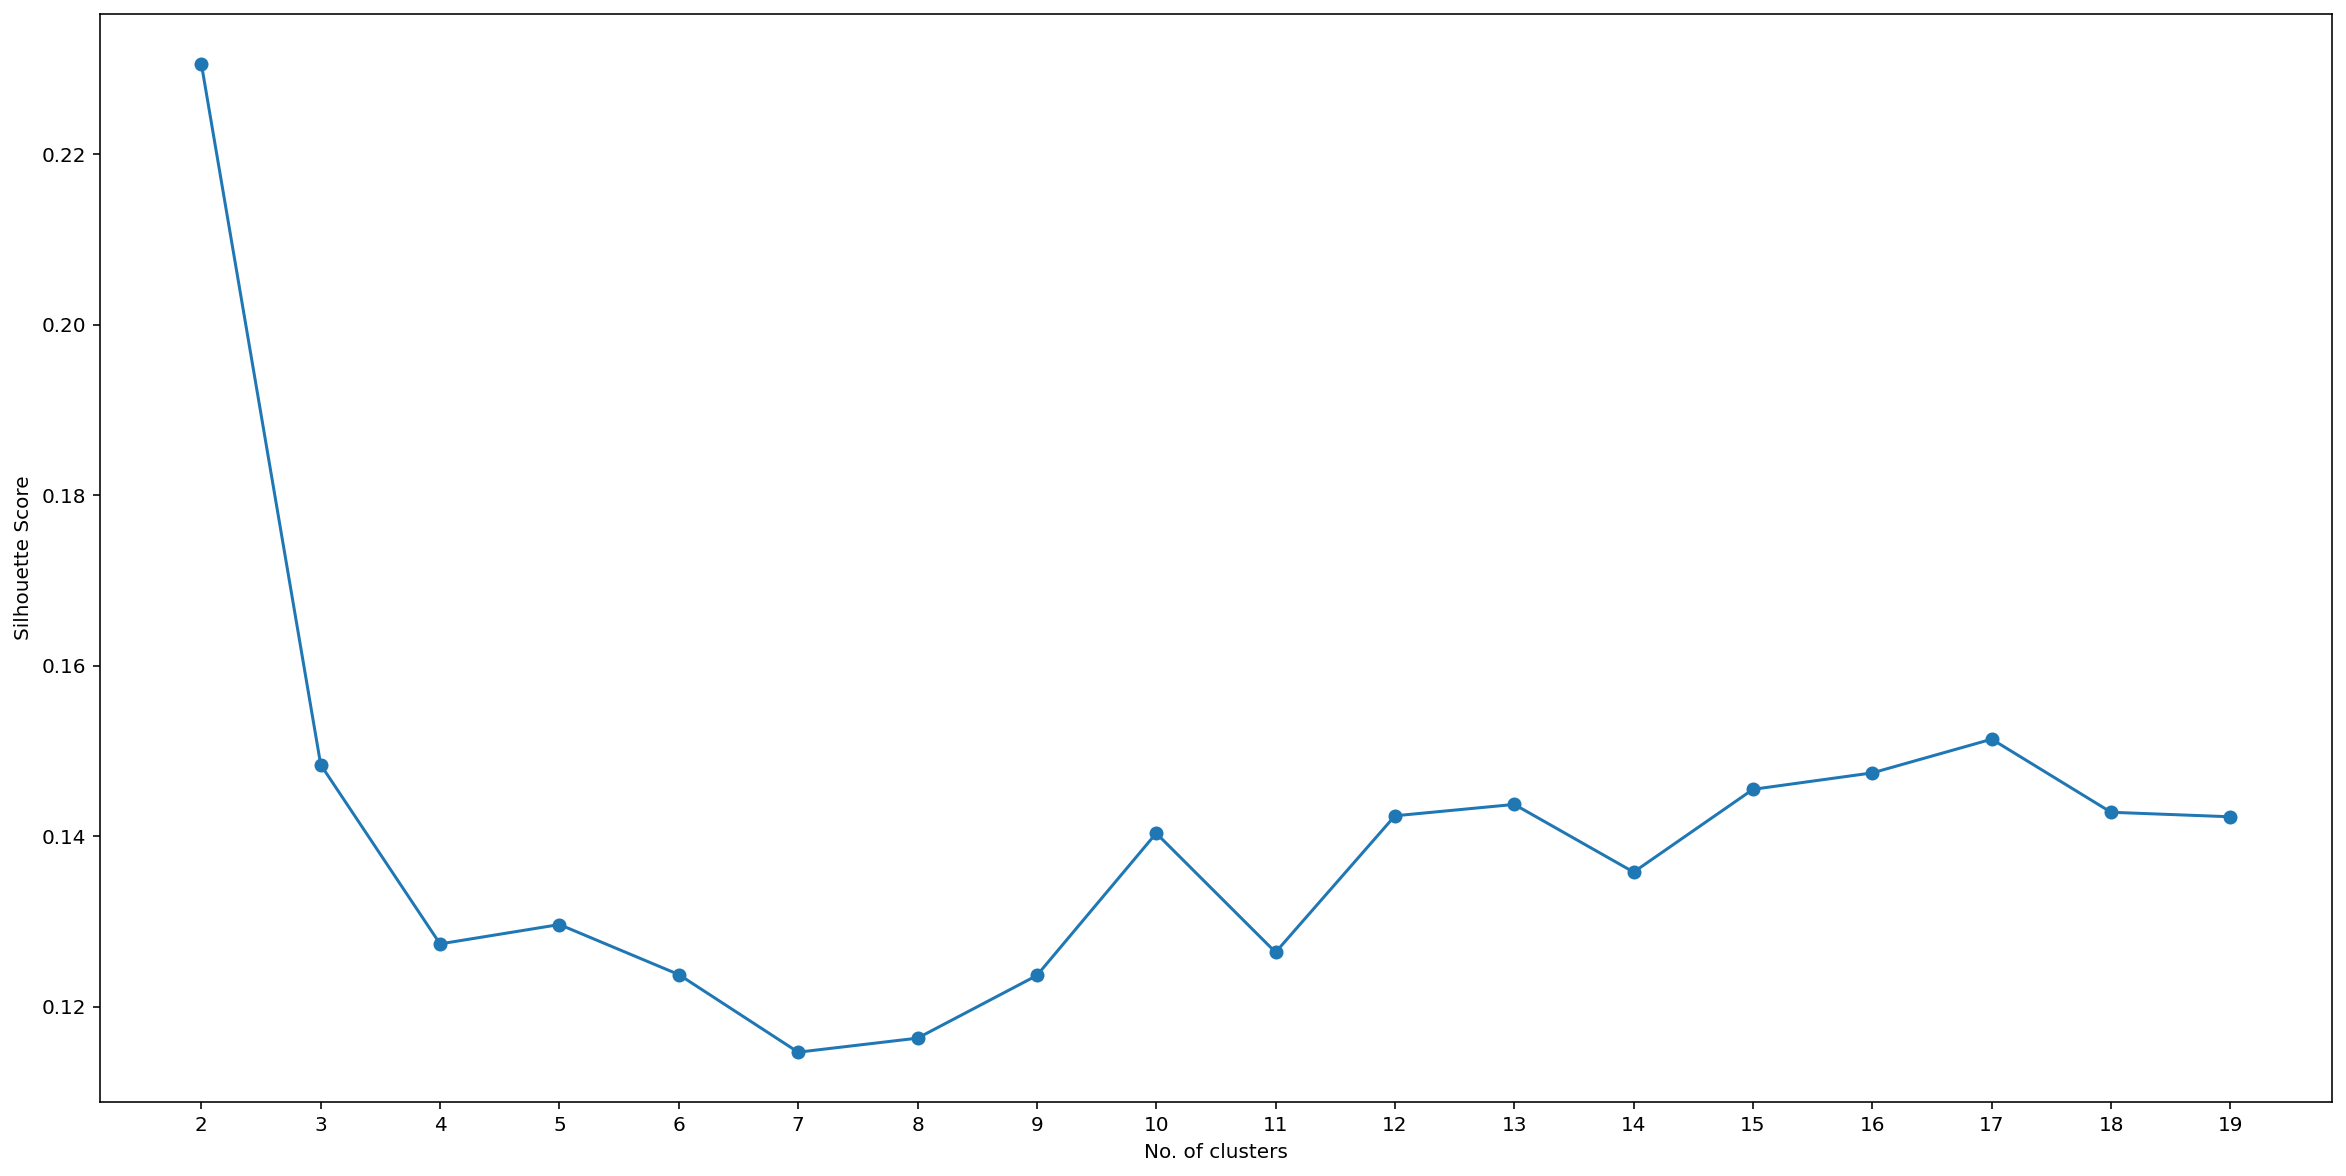

In [52]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [53]:
# set number of clusters
kclusters = 5

#guatemala_grouped_clustering = mexico_grouped.drop('Neighborhood', 1)

# run k-means clustering
BJkmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BJ_grouped_clustering)

# check cluster labels generated for each row in the dataframe
BJkmeans.labels_[0:10] 

array([3, 3, 2, 1, 2, 2, 0, 3, 4, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [54]:
# add clustering labels
BJ_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', BJkmeans.labels_)

BJ_merged = BJ_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
BJ_merged = BJ_merged.join(BJ_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

BJ_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BENITO JUAREZ,NARVARTE V,19.386051,-99.157160,1,Mexican Restaurant,Taco Place,Bakery,Coffee Shop,Pharmacy,Seafood Restaurant,BBQ Joint,Pizza Place,Ice Cream Shop,Café
1,BENITO JUAREZ,PORTALES III,19.363211,-99.148887,1,Taco Place,Mexican Restaurant,Coffee Shop,Bakery,Restaurant,Seafood Restaurant,Spa,Pizza Place,Dance Studio,Café
2,BENITO JUAREZ,DEL VALLE VII,19.368136,-99.171326,3,Ice Cream Shop,Coffee Shop,Bakery,Pizza Place,Gym / Fitness Center,Burger Joint,Mexican Restaurant,Taco Place,Multiplex,Vegetarian / Vegan Restaurant
3,BENITO JUAREZ,NAPOLES (AMPL),19.387303,-99.177728,4,Mexican Restaurant,Taco Place,Japanese Restaurant,Bakery,American Restaurant,Café,Food Truck,Ice Cream Shop,Sushi Restaurant,Seafood Restaurant
4,BENITO JUAREZ,LETRAN VALLE,19.376132,-99.155067,4,Mexican Restaurant,Taco Place,Bakery,Coffee Shop,Food Truck,Pet Store,Sushi Restaurant,Ice Cream Shop,Restaurant,Pizza Place


Finally, let's visualize the resulting clusters

In [55]:
# create map
BJ_map_clusters = folium.Map(location=[latitude_BJ, longitude_BJ], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BJ_merged['Latitude'], BJ_merged['Longitude'], BJ_merged['Neighborhood'], BJ_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(BJ_map_clusters)
       
BJ_map_clusters

### Miguel Hidalgo

In [56]:
MH_grouped_clustering = MH_grouped.drop('Neighborhood', 1)

In [57]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    mhc = MH_grouped_clustering
    MH_kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(mhc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(mhc, MH_kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

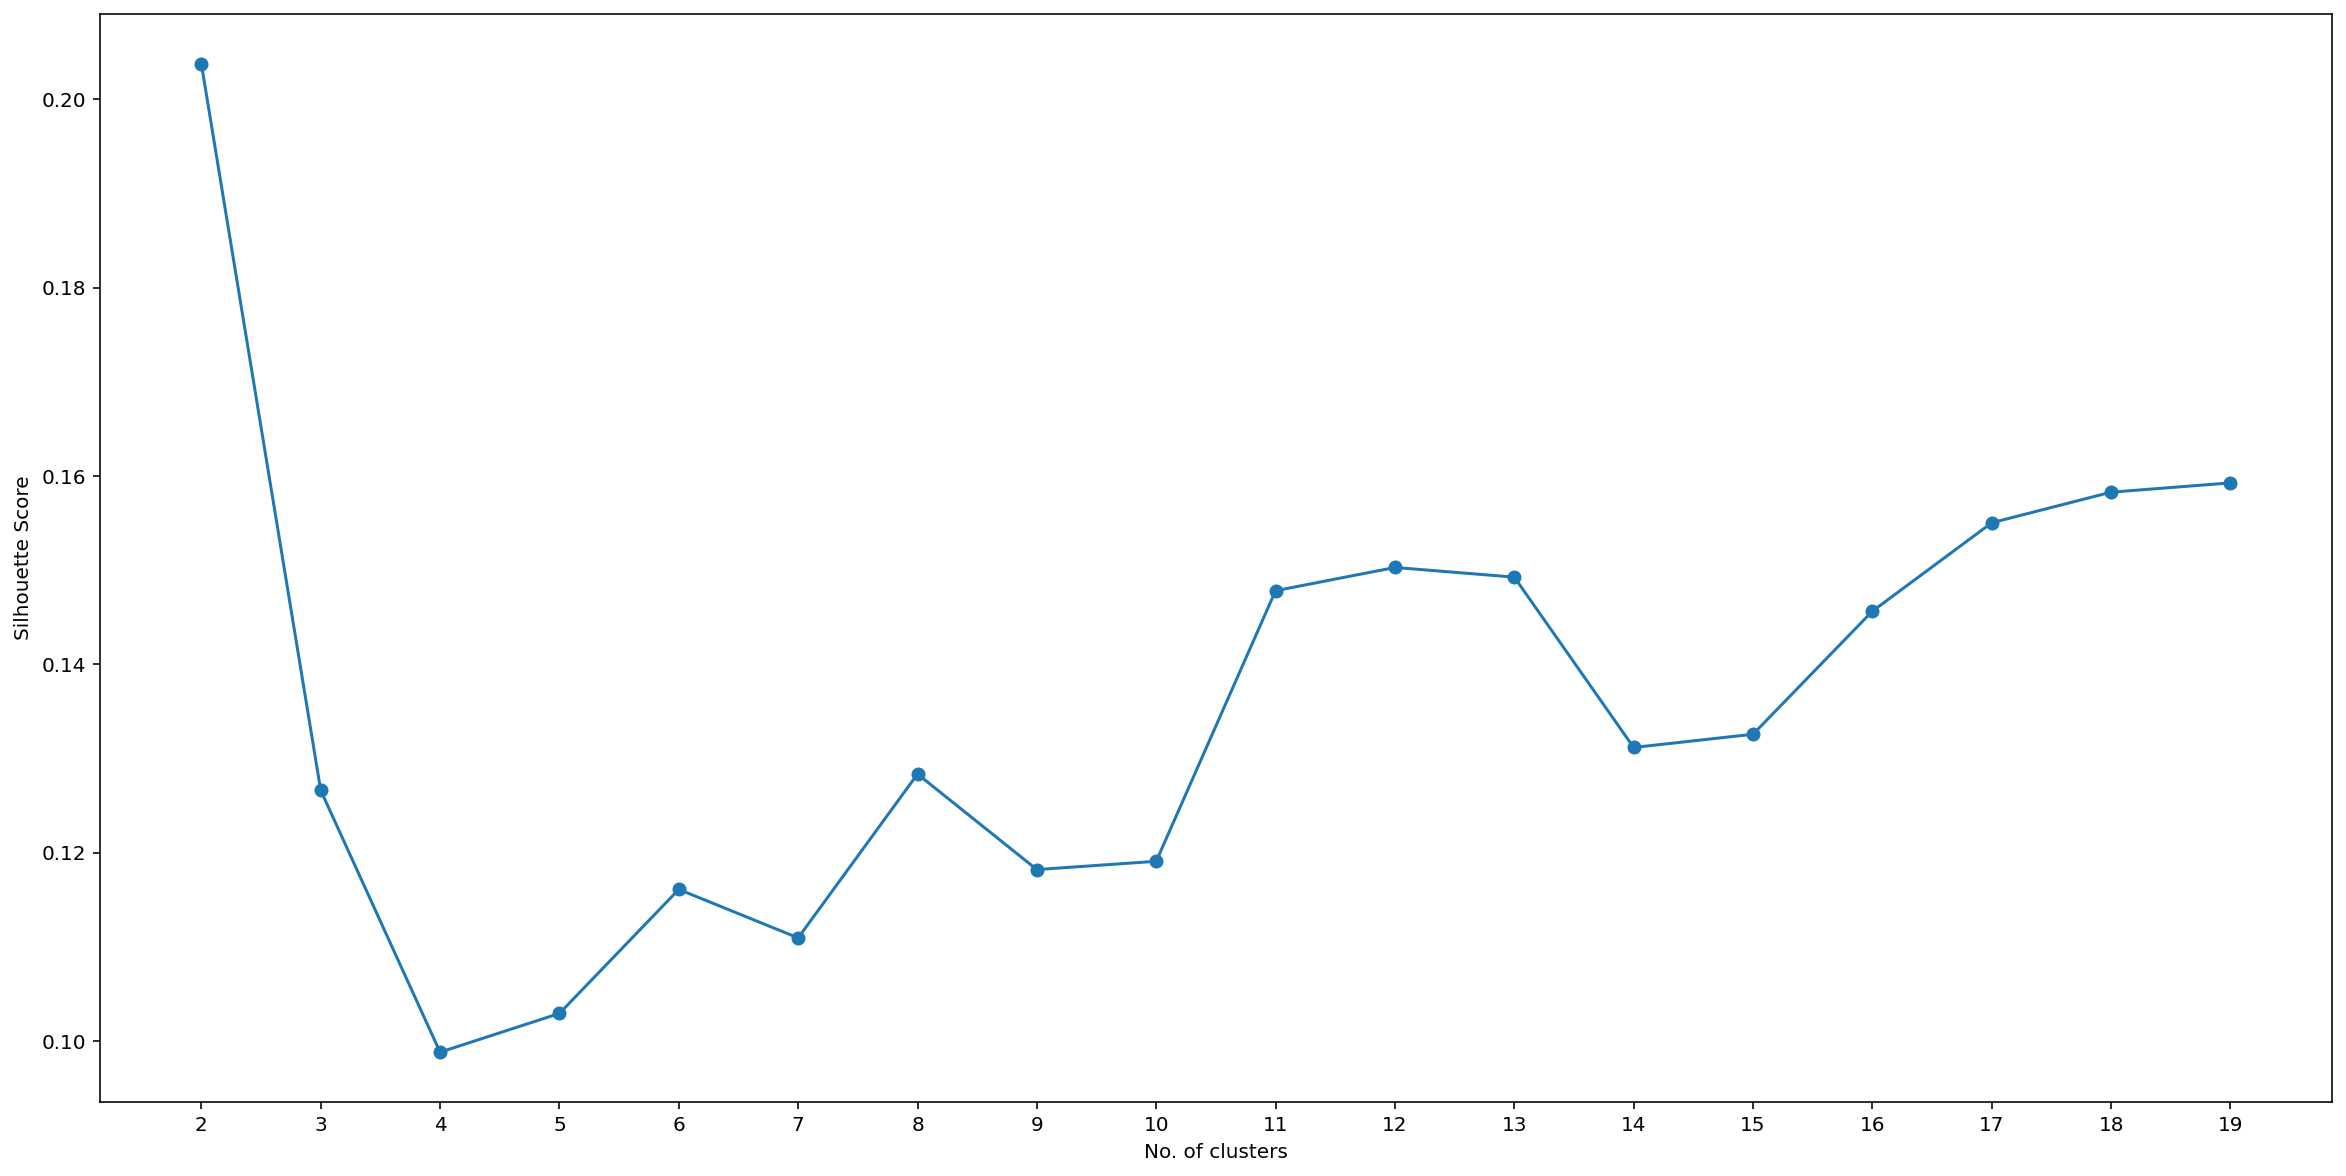

In [58]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [59]:
# set number of clusters
MHkclusters = 5

#guatemala_grouped_clustering = mexico_grouped.drop('Neighborhood', 1)

# run k-means clustering
MHkmeans = KMeans(n_clusters=MHkclusters, random_state=0).fit(MH_grouped_clustering)

# check cluster labels generated for each row in the dataframe
MHkmeans.labels_[0:10] 

array([3, 1, 3, 2, 1, 1, 3, 3, 3, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [60]:
# add clustering labels
MH_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', MHkmeans.labels_)

MH_merged = MH_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
MH_merged = MH_merged.join(MH_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

MH_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,MIGUEL HIDALGO,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,4,Restaurant,Coffee Shop,Bakery,Steakhouse,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Gym,Taco Place,Spa
1,MIGUEL HIDALGO,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),19.410616,-99.226249,4,Forest,Park,Bookstore,Scenic Lookout,Dessert Shop,Photography Lab,Restaurant,Coffee Shop,Exhibit,Chinese Restaurant
2,MIGUEL HIDALGO,DEL BOSQUE (POLANCO),19.434219,-99.209404,0,Ice Cream Shop,Coffee Shop,Bakery,Café,Mexican Restaurant,Taco Place,Jewelry Store,Seafood Restaurant,Boutique,Restaurant
3,MIGUEL HIDALGO,5 DE MAYO,19.448459,-99.199910,3,Mexican Restaurant,Taco Place,Coffee Shop,Restaurant,Burger Joint,Shopping Mall,Gym / Fitness Center,Movie Theater,Bakery,Steakhouse
4,MIGUEL HIDALGO,PLUTARCO ELIAS CALLES,19.454840,-99.169189,3,Mexican Restaurant,Taco Place,Restaurant,Bakery,Sushi Restaurant,Bar,Beer Garden,Salad Place,Food,Burger Joint


Finally, let's visualize the resulting clusters

In [84]:
# create map
MH_map_clusters = folium.Map(location=[latitude_MH, longitude_MH], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MH_merged['Latitude'], MH_merged['Longitude'], MH_merged['Neighborhood'], MH_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(MH_map_clusters)
       
MH_map_clusters

## 8. Comparing both boroughs

Most common categories in Benito Juarez

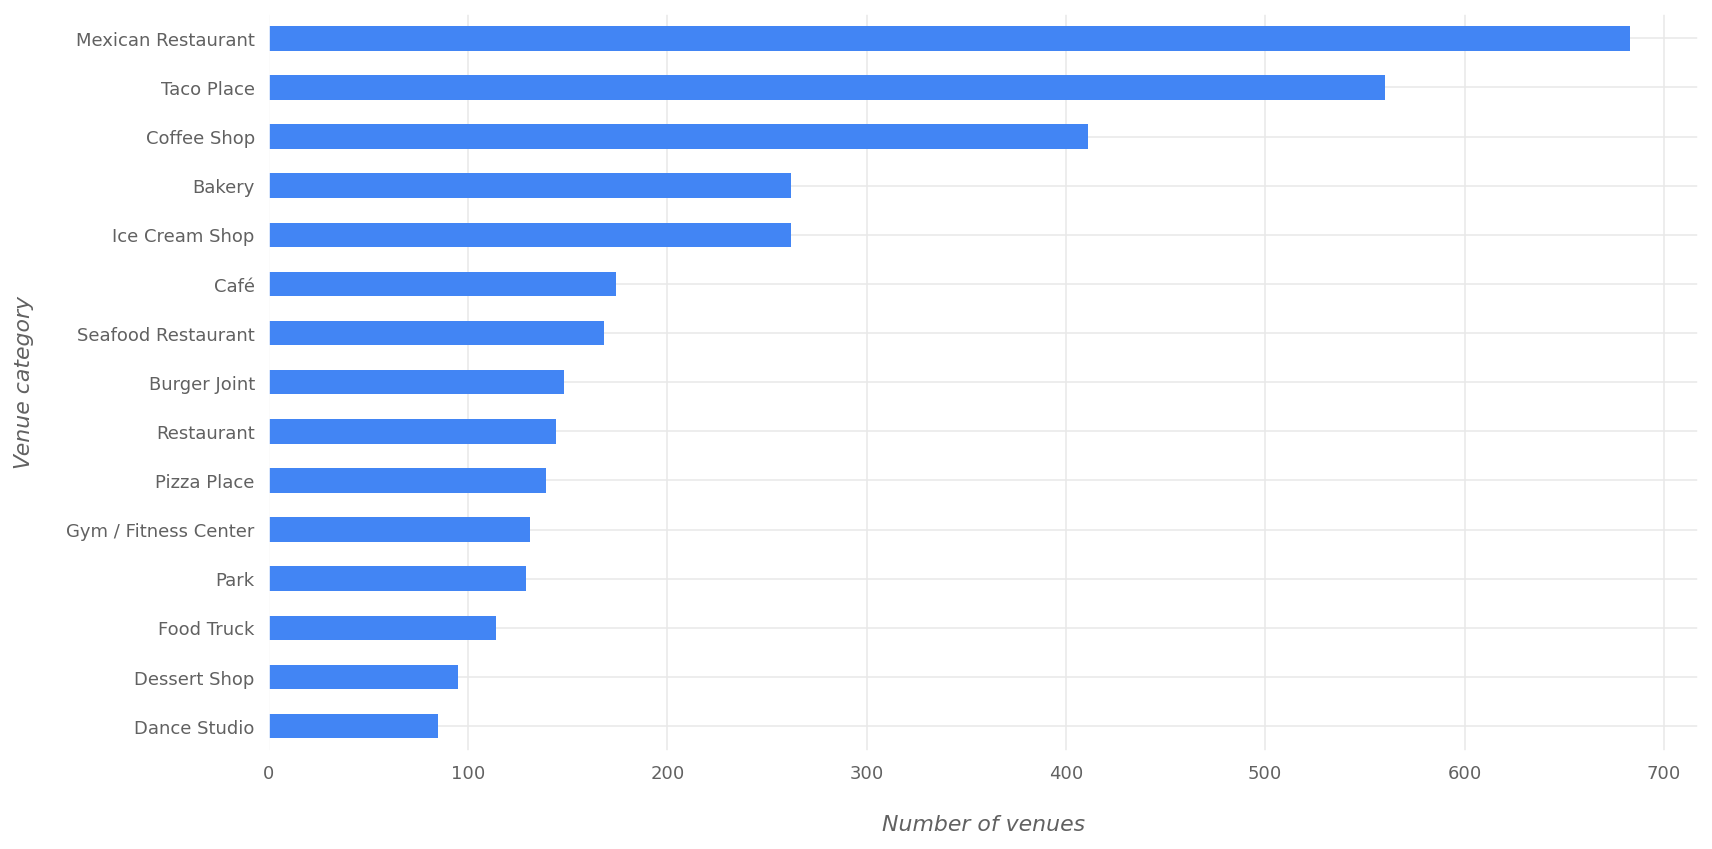

In [62]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
BJ_top_vc = BJ_venues['Venue Category'].value_counts(normalize=False)
ax = BJ_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-BJ.png', dpi=300)

Most common categories in Miguel Hidalgo

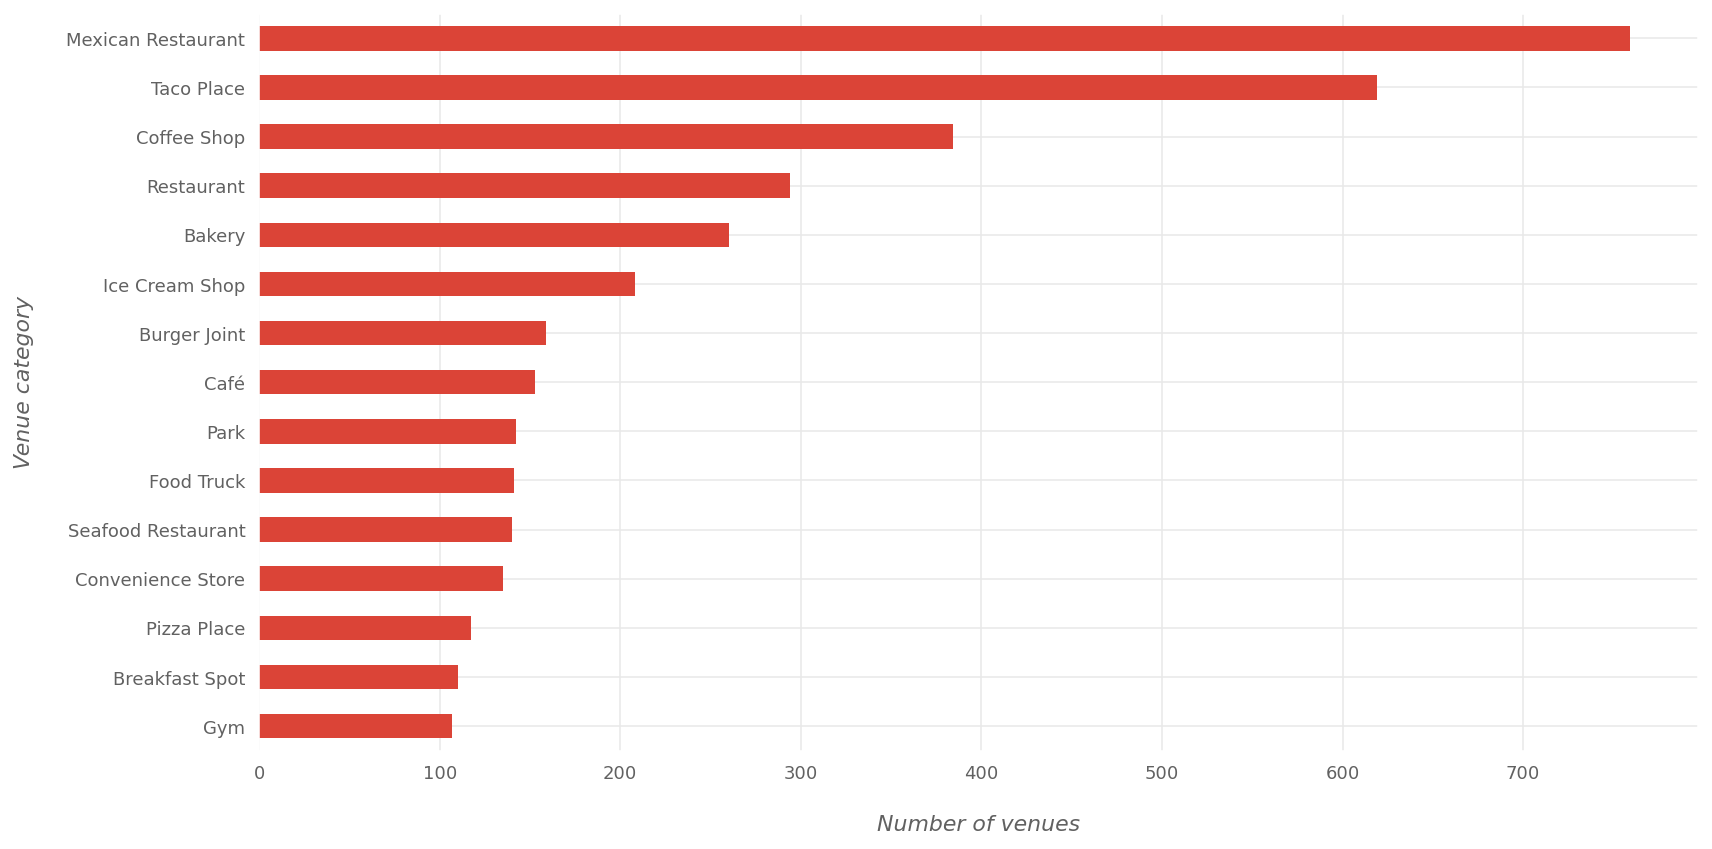

In [63]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
MH_top_vc = MH_venues['Venue Category'].value_counts(normalize=False)
ax = MH_top_vc.head(15).plot(kind='barh', color=pc[1]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-MH.png', dpi=300)

Which Venue Categories Exist in More Benito Juarez Neighborhoods?

64 neighborhoods in Benito Juarez


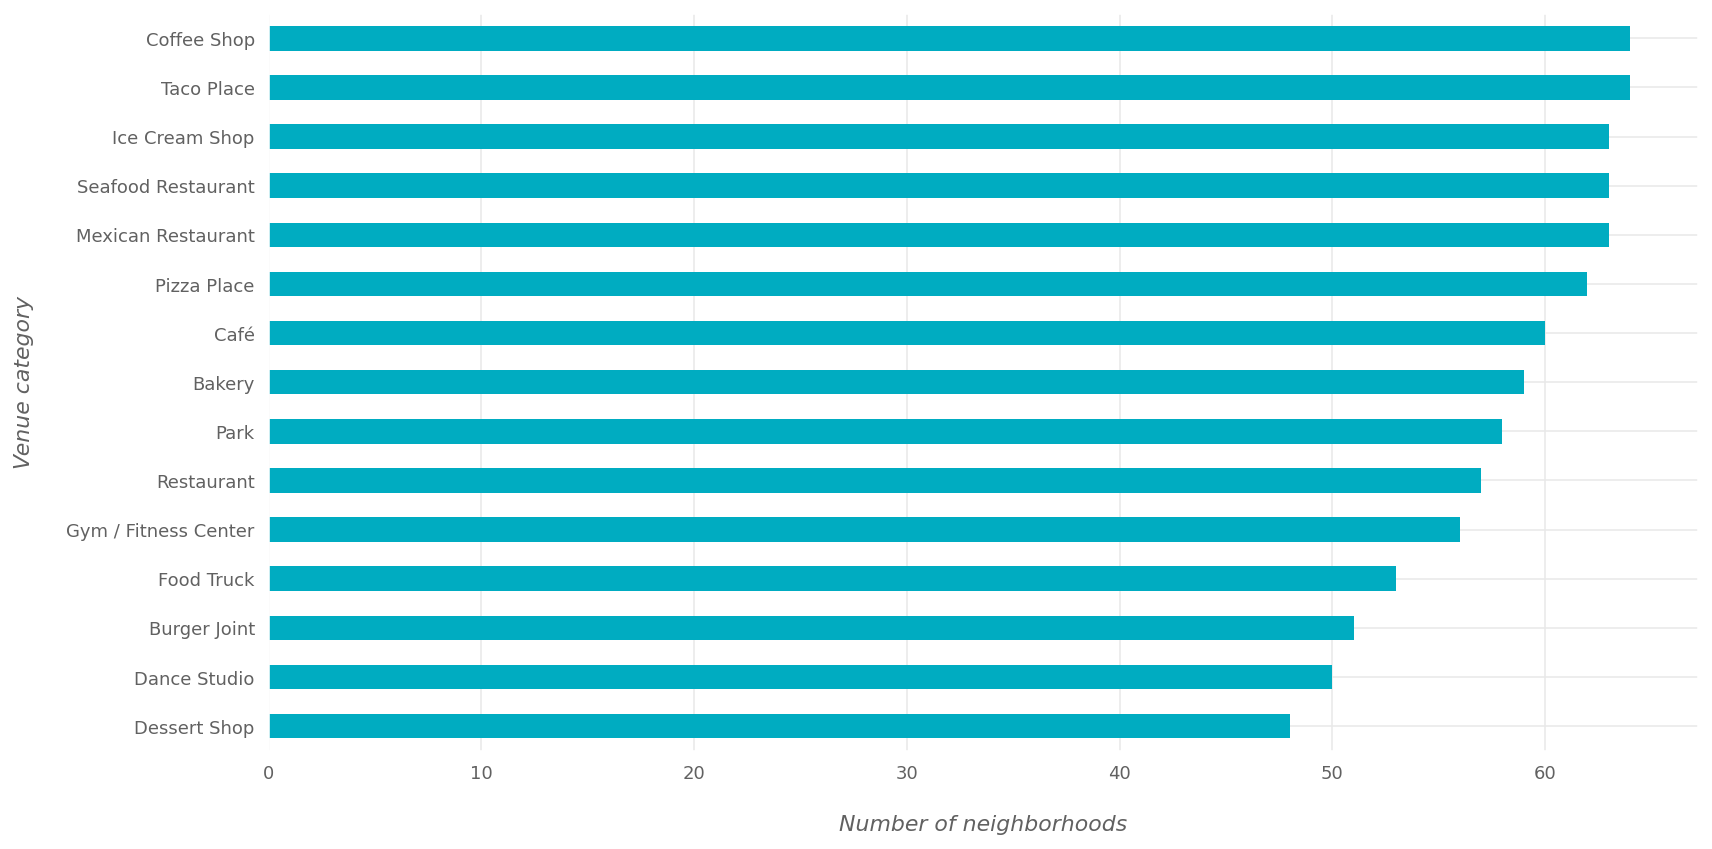

In [64]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
BJ_g = BJ_onehot.groupby('Neighborhood').max().reset_index()
BJ_p = BJ_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Benito Juarez".format(BJ_g.shape[0]))
ax = BJ_p.head(15).plot(kind='barh', color=pc[5]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-BJ.png', dpi=300)

Which Venue Categories Exist in More Miguel Hidalgo Neighborhoods?

88 neighborhoods in Miguel Hidalgo


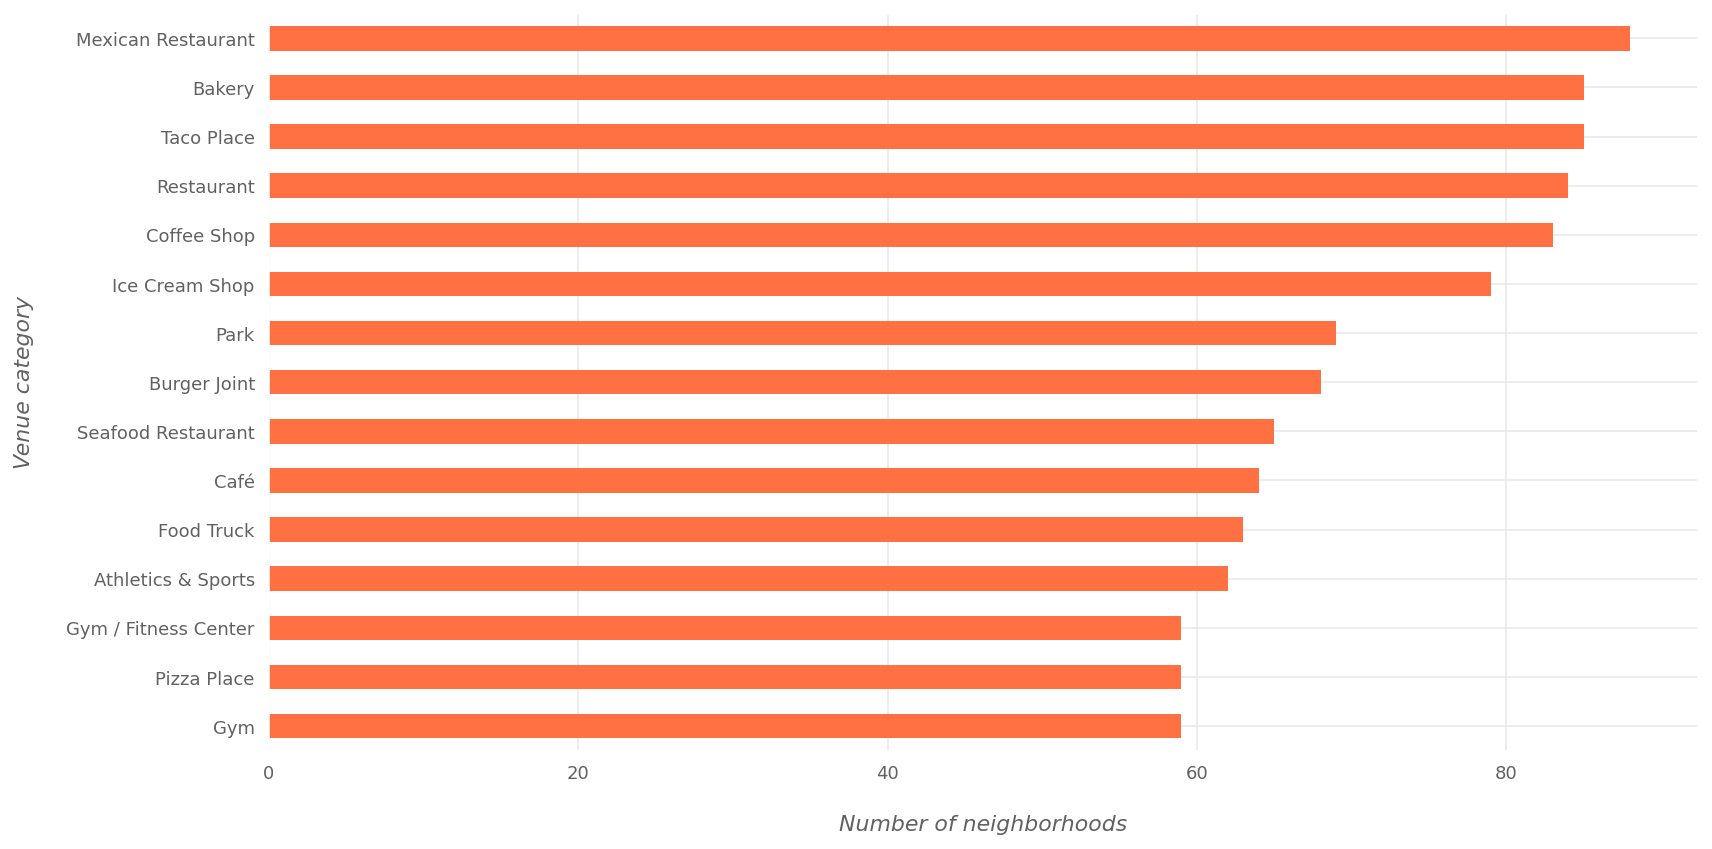

In [65]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
MH_g = MH_onehot.groupby('Neighborhood').max().reset_index()
MH_p = MH_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Miguel Hidalgo".format(MH_g.shape[0]))
ax = MH_p.head(15).plot(kind='barh', color=pc[6]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-MH.png', dpi=300)

Rare Categories in Benito Juarez

In [66]:
BJ_bot_vc = BJ_venues['Venue Category'].value_counts(normalize=False)
BJ_bot_vc = BJ_bot_vc.tail(15).to_frame('Count')
BJ_bot_vc.index.names = ['Venue Category']
BJ_bot_vc

,Count
Venue Category,
Mountain,1
Outdoor Sculpture,1
Parking,1
Planetarium,1
Car Wash,1
Other Nightlife,1
Lighthouse,1
Gift Shop,1
Cafeteria,1


Rare Categories in Miguel Hidalgo

In [67]:
MH_bot_vc = MH_venues['Venue Category'].value_counts(normalize=False)
MH_bot_vc = MH_bot_vc.tail(15).to_frame('Count')
MH_bot_vc.index.names = ['Venue Category']
MH_bot_vc

,Count
Venue Category,
New American Restaurant,1
Event Space,1
Shoe Store,1
Monument / Landmark,1
Other Great Outdoors,1
Campground,1
Resort,1
Golf Course,1
Venezuelan Restaurant,1


In [68]:
clmns_BJ_only = set(BJ_grouped.columns).difference(set(MH_grouped.columns))
clmns_MH_only = set(MH_grouped.columns).difference(set(BJ_grouped.columns))

In [69]:
BJ_grouped_ = BJ_grouped.copy()
BJ_grouped_['Neighborhood'] = BJ_grouped_['Neighborhood'].apply(lambda x: x + '_Benito Juarez')
MH_grouped_ = MH_grouped.copy()
MH_grouped_['Neighborhood'] = MH_grouped_['Neighborhood'].apply(lambda x: x + '_Miguel Hidalgo')

for c in clmns_BJ_only:
    MH_grouped_[c] = 0
for c in clmns_MH_only:
    BJ_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood'] + sorted(list(BJ_grouped_.drop('Neighborhood', axis=1).columns), key=str.lower)
BJ_grouped_ = BJ_grouped_[all_clmns_sorted]
MH_grouped_ = MH_grouped_[all_clmns_sorted]
    
BJ_MH_grouped = pd.concat([BJ_grouped_, MH_grouped_]).reset_index(drop=True)

In [70]:
BJ_MH_grouped.loc[60:69,]

,Neighborhood,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,BBQ Joint,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Football Field,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,IT Services,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Notary,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rock Climbing Spot,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stables,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket

In [71]:
BJ_MH_grouped.shape

(152, 313)

In [72]:
BJ_MH_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
BJ_MH_neighborhoods_categories_sorted['Neighborhood'] = BJ_MH_grouped['Neighborhood']
num_top_cat=10

for ind in np.arange(BJ_MH_grouped.shape[0]):
    BJ_MH_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        BJ_MH_grouped.iloc[ind, :], num_top_cat)

BJ_MH_neighborhoods_categories_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ACACIAS_Benito Juarez,Coffee Shop,Mexican Restaurant,Bakery,Ice Cream Shop,Boutique,Cosmetics Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Burger Joint
1,ACTIPAN_Benito Juarez,Ice Cream Shop,Café,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Argentinian Restaurant,Taco Place,Supermarket,Diner,Dessert Shop
2,ALAMOS I_Benito Juarez,Mexican Restaurant,Taco Place,Bakery,Burger Joint,Seafood Restaurant,Coffee Shop,Dessert Shop,Café,Ice Cream Shop,Restaurant
3,ALAMOS II_Benito Juarez,Taco Place,Mexican Restaurant,Burger Joint,Café,Coffee Shop,Ice Cream Shop,Bakery,Breakfast Spot,Dance Studio,Bar
4,ALBERT_Benito Juarez,Mexican Restaurant,Taco Place,Breakfast Spot,Food Truck,Coffee Shop,Bakery,Gym,Soccer Field,Pool,Flea Market


In [73]:
# the number of clusters
kclusters = 5

BJ_MH_grouped_clustering = BJ_MH_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BJ_MH_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 1, 2, 2, 4, 4, 4, 0])

In [74]:
# add clustering labels
BJ_MH_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

BJ_MH_merged = BJ_MH_neighborhoods_categories_sorted.set_index('Neighborhood')

BJ_MH_merged.iloc[61:69] # check the last columns!

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
VILLA DE CORTES_Benito Juarez,2,Mexican Restaurant,Taco Place,Ice Cream Shop,Coffee Shop,Bakery,Park,Burger Joint,Dessert Shop,Pizza Place,Gym
XOCO_Benito Juarez,0,Coffee Shop,Ice Cream Shop,Bakery,Taco Place,Boutique,Sushi Restaurant,Shopping Mall,Lingerie Store,Cosmetics Shop,Pizza Place
ZACAHUITZCO_Benito Juarez,2,Mexican Restaurant,Taco Place,Food Truck,Dessert Shop,Café,Coffee Shop,Gym,Sushi Restaurant,Bakery,Sandwich Place
10 DE ABRIL_Miguel Hidalgo,4,Mexican Restaurant,Coffee Shop,Restaurant,Taco Place,Gym / Fitness Center,Ice Cream Shop,Bakery,Sandwich Place,Shopping Mall,Park
16 DE SEPTIEMBRE_Miguel Hidalgo,1,Taco Place,Mexican Restaurant,Convenience Store,Food Truck,Coffee Shop,Restaurant,Pharmacy,Seafood Restaurant,Bus Station,Bakery
5 DE MAYO_Miguel Hidalgo,4,Mexican Restaurant,Taco Place,Coffee Shop,Restaurant,Burger Joint,Shopping Mall,Gym / Fitness Center,Bakery,Movie Theater,Residential Building (Apartment / Condo)
AGRICULTURA_Miguel Hidalgo,2,Mexican Restaurant,Bakery,Taco Place,Pizza Place,Salad Place,Restaurant,Burger Joint,Coffee Shop,Ice Cream Shop,Plaza
AHUEHUETES ANAHUAC_Miguel Hidalgo,1,Taco Place,Mexican Restaurant,Breakfast Spot,Coffee Shop,Convenience Store,Bar,Bakery,Food Truck,Park,Pizza Place


In [75]:
BJ_MH_neighborhoods_categories_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,ACACIAS_Benito Juarez,Coffee Shop,Mexican Restaurant,Bakery,Ice Cream Shop,Boutique,Cosmetics Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Burger Joint
1,0,ACTIPAN_Benito Juarez,Ice Cream Shop,Café,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Argentinian Restaurant,Taco Place,Supermarket,Diner,Dessert Shop
2,2,ALAMOS I_Benito Juarez,Mexican Restaurant,Taco Place,Bakery,Burger Joint,Seafood Restaurant,Coffee Shop,Dessert Shop,Café,Ice Cream Shop,Restaurant
3,1,ALAMOS II_Benito Juarez,Taco Place,Mexican Restaurant,Burger Joint,Café,Coffee Shop,Ice Cream Shop,Bakery,Breakfast Spot,Dance Studio,Bar
4,2,ALBERT_Benito Juarez,Mexican Restaurant,Taco Place,Breakfast Spot,Food Truck,Coffee Shop,Bakery,Gym,Soccer Field,Pool,Flea Market


In [76]:
BJ_data_ = BJ_data.copy()
BJ_data_['Neighborhood'] = BJ_data_['Neighborhood'].apply(lambda x: x + '_Benito Juarez')
MH_data_ = MH_data.copy()
MH_data_['Neighborhood'] = MH_data_['Neighborhood'].apply(lambda x: x + '_Miguel Hidalgo')

BJ_MH_data_=pd.DataFrame()
BJ_MH_data_=BJ_data_.append(MH_data_)
BJ_MH_merged_=BJ_MH_neighborhoods_categories_sorted.copy()

# merge data to add latitude/longitude for each neighborhood
BJ_MH_merged_ = BJ_MH_merged_.join(BJ_MH_data_.set_index('Neighborhood'), on='Neighborhood')


In [77]:
# create map
CDMX_map_clusters = folium.Map(location=[19.4024193, -99.2107797], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BJ_MH_merged_['Latitude'], BJ_MH_merged_['Longitude'], BJ_MH_merged_['Neighborhood'], BJ_MH_merged_['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-3],
        fill=True,
        fill_color=rainbow[cluster-3],
        fill_opacity=0.7).add_to(CDMX_map_clusters)
       
CDMX_map_clusters

In [78]:
c1 = BJ_MH_merged.loc[BJ_MH_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c2 = BJ_MH_merged.loc[BJ_MH_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c3 = BJ_MH_merged.loc[BJ_MH_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c4 = BJ_MH_merged.loc[BJ_MH_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c5 = BJ_MH_merged.loc[BJ_MH_merged['Cluster Labels'] == 4, :]
print(c5.shape)

(24, 11)
(34, 11)
(34, 11)
(14, 11)
(46, 11)


In [79]:
clust_cats = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('Benito Juarez'):
            nn = n[:-14]
            clust_cats[i].extend(list(BJ_venues[BJ_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-15]
            clust_cats[i].extend(list(MH_venues[MH_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100

In [80]:

#tbl_bck = "#363636"
#tbl_hdr_bck = "#363636"
#tbl_txt = "#BBBBBB"


tbl_bck = "#ebebeb"
tbl_hdr_bck = "#242424"
tbl_txt = "#3b3939"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "11pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#f0f4f5")]),  ## % Venue color
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#f0f4f5")]),  ## Category color
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#cce6ed"), ("color", "001a2e")]),
]

In [81]:
for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(5).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)

,% of venues
Category,
Coffee Shop,6.595448
Bakery,4.133767
Mexican Restaurant,4.040873
Ice Cream Shop,3.901533
Seafood Restaurant,3.204830


,% of venues
Category,
Taco Place,12.346814
Mexican Restaurant,10.753676
Coffee Shop,5.422794
Bakery,3.890931
Restaurant,3.523284


,% of venues
Category,
Mexican Restaurant,17.504964
Taco Place,13.666446
Coffee Shop,3.970880
Bakery,3.507611
Restaurant,3.375248


,% of venues
Category,
Mexican Restaurant,7.988381
Coffee Shop,6.535948
Boutique,3.994190
Ice Cream Shop,3.195352
Shopping Mall,2.832244


,% of venues
Category,
Mexican Restaurant,8.293570
Taco Place,6.271302
Coffee Shop,6.044081
Bakery,3.794592
Ice Cream Shop,3.726426


In [82]:
n_counts = []

for c in clusters:
    BJ_c = 0
    MH_c = 0
    for n in c.index.values:
        if n.endswith('Benito Juarez'):
            BJ_c += 1
        else:
            MH_c += 1
    n_counts.append((BJ_c, MH_c))

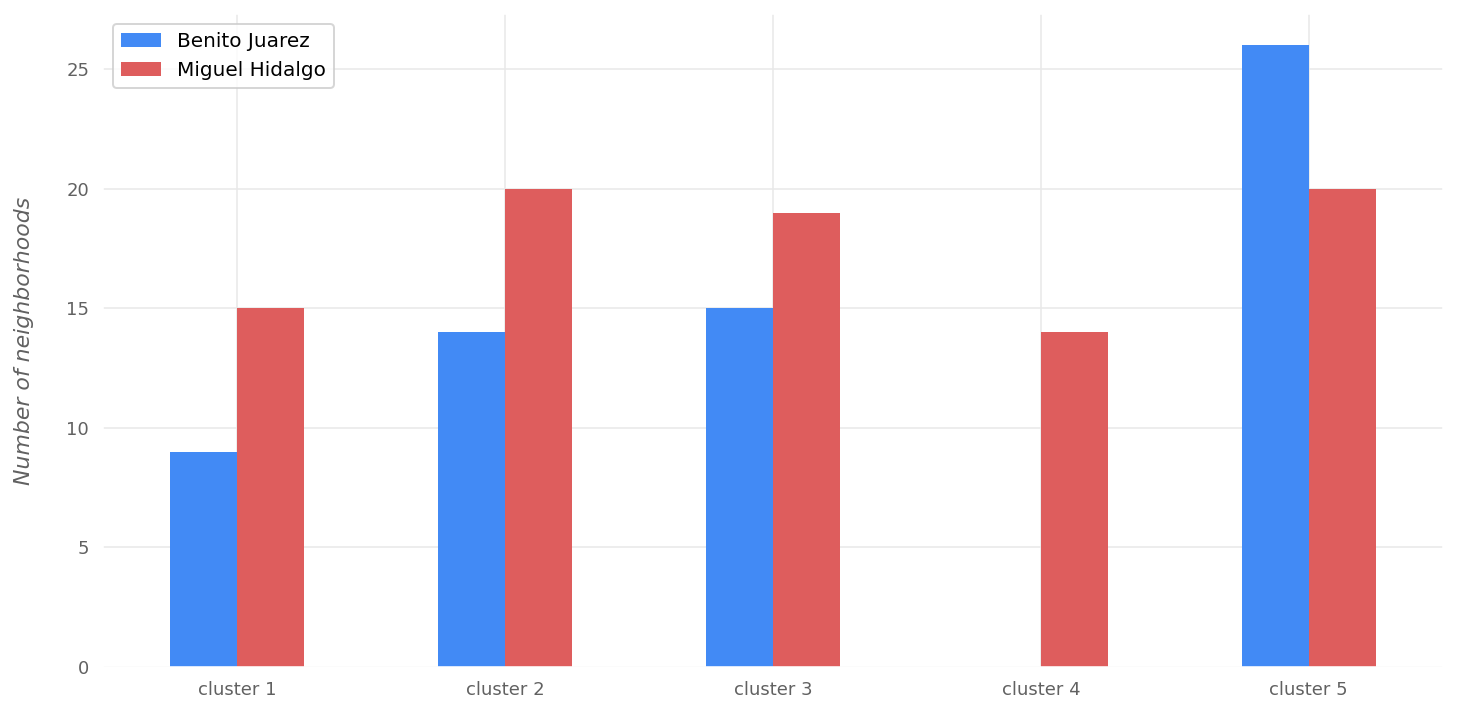

In [83]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'Benito Juarez': [x[0] for x in n_counts],
    'Miguel Hidalgo': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
city_c_df.plot(kind='bar', color=['#428af5', '#de5d5d'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
fig.savefig('city-count.png', dpi=300)

In [86]:
map_BJ.save('map_BJ.png')
map_MH.save('map_MH.png')
MH_map_clusters.save('MH_map_clusters.png')
BJ_map_clusters.save('MJ_map_clusters.png')
CDMX_map_clusters.save('CDMX_map_clusters.png')